In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras

In [2]:
data_dir = './test'


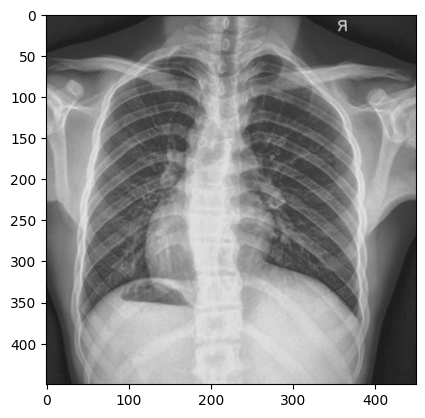

In [3]:
import cv2
example=cv2.imread('./test/Normal/01.jpeg')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
plt.imshow(example)


In [4]:
print(example)
example.shape

[[[47 47 47]
  [47 47 47]
  [47 47 47]
  ...
  [43 43 43]
  [44 44 44]
  [44 44 44]]

 [[48 48 48]
  [48 48 48]
  [48 48 48]
  ...
  [43 43 43]
  [43 43 43]
  [43 43 43]]

 [[49 49 49]
  [49 49 49]
  [49 49 49]
  ...
  [43 43 43]
  [42 42 42]
  [42 42 42]]

 ...

 [[47 47 47]
  [46 46 46]
  [46 46 46]
  ...
  [37 37 37]
  [37 37 37]
  [37 37 37]]

 [[44 44 44]
  [43 43 43]
  [42 42 42]
  ...
  [39 39 39]
  [36 36 36]
  [36 36 36]]

 [[44 44 44]
  [43 43 43]
  [42 42 42]
  ...
  [39 39 39]
  [36 36 36]
  [36 36 36]]]


(450, 450, 3)

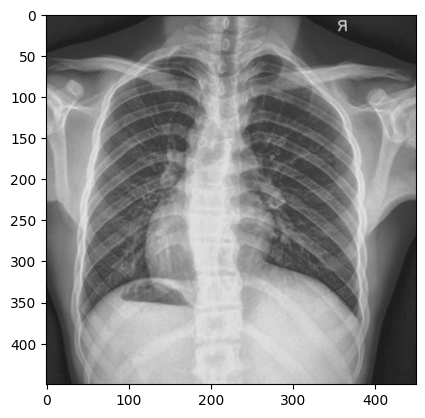

In [5]:
example=cv2.imread('./test/Normal/01.jpeg')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
plt.imshow(example)

In [6]:
example.shape

(450, 450, 3)

In [7]:

from tensorflow.keras.utils import image_dataset_from_directory
#train_data=image_dataset_from_directory(data_dir)
image_height = 256
batch_size=32
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=3,
  image_size=(image_height, image_height),
  batch_size=batch_size)

Found 5246 files belonging to 9 classes.
Using 4197 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)
len(class_names)

['Asthma', 'Atelectasis', 'Bronchitis', 'COPD', 'Normal', 'Pleural Effusion', 'Pneumonia', 'Pulmonary Fibrosis', 'Tuberculose']


9

In [9]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=3,
  image_size=(image_height, image_height),
  batch_size=batch_size)

Found 5246 files belonging to 9 classes.
Using 1049 files for validation.


In [11]:
from keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Flatten, Dense

resnet_model = Sequential()

pretrained_model= ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',
                   classes=3,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(15, activation='softmax'))

In [12]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [13]:
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 24644495 (94.01 MB)
Trainable params: 1056783 (4.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [14]:
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data = val_ds,  
  epochs=epochs
)

Epoch 1/5
132/132 [==============================] - 562s 4s/step - loss: 1.0668 - accuracy: 0.6626 - val_loss: 0.5147 - val_accuracy: 0.8494
Epoch 2/5
132/132 [==============================] - 578s 4s/step - loss: 0.3538 - accuracy: 0.9023 - val_loss: 0.2823 - val_accuracy: 0.9285
Epoch 3/5
132/132 [==============================] - 531s 4s/step - loss: 0.1870 - accuracy: 0.9538 - val_loss: 0.2220 - val_accuracy: 0.9390
Epoch 4/5
132/132 [==============================] - 522s 4s/step - loss: 0.1080 - accuracy: 0.9755 - val_loss: 0.1242 - val_accuracy: 0.9714
Epoch 5/5
132/132 [==============================] - 528s 4s/step - loss: 0.0666 - accuracy: 0.9867 - val_loss: 0.1041 - val_accuracy: 0.9724


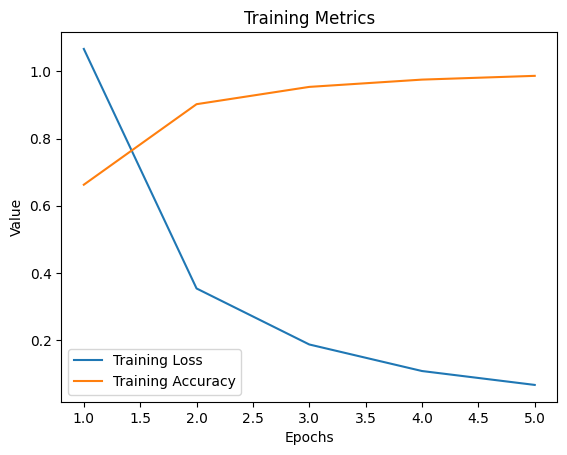

In [19]:
resnet_model.save('lungs.h5')
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

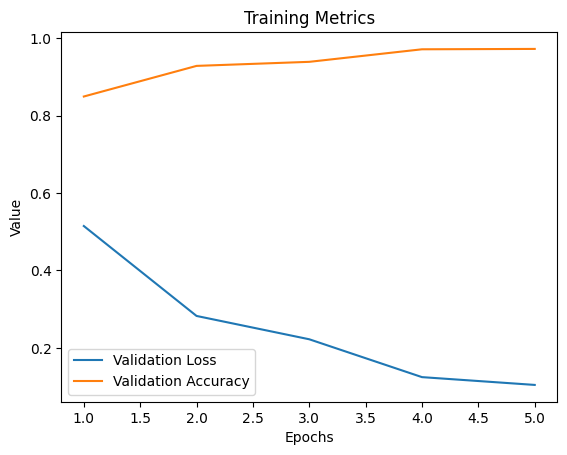

In [20]:
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


In [21]:
def predict_img(fpath):
    
    image=cv2.imread(fpath)
    example = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(example)
    image_resized= cv2.resize(image, (image_height,image_height))
    image=np.expand_dims(image_resized,axis=0)
    pred=resnet_model.predict(image)
    output=class_names[np.argmax(pred)]
    print(output)

Now let us look at the predictions for test images!

1/1 [==============================] - 0s 160ms/step
Normal


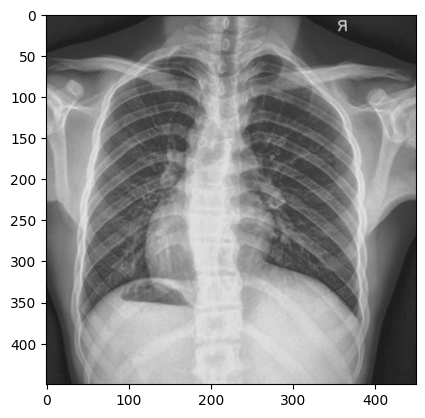

In [22]:
predict_img('./test/Normal/01.jpeg')